## Import required libraries including SageMaker Python SDK

In [1]:
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import gmtime, strftime
from IPython.display import FileLink, FileLinks

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

import boto3
import sagemaker
from sagemaker import clarify
from sagemaker.inputs import TrainingInput
from sagemaker.transformer import Transformer
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

### Update SageMaker SDK if necessary 

In [2]:
if int(sagemaker.__version__.split('.')[0]) != 2:
    !pip install sagemaker==2.24.1
    print("Updating SageMakerVersion. Please restart the kernel")
else:
    print("SageMaker SDK version is good")

SageMaker SDK version is good


### Set region, boto3 and SageMaker SDK variables

In [3]:
boto_session = boto3.Session()
region = boto_session.region_name
print("Region = {}".format(region))

s3_client = boto3.client('s3', region_name=region)

sagemaker_boto_client = boto_session.client('sagemaker')

sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_boto_client)

sagemaker_role = sagemaker.get_execution_role()

random_state = 42

Region = us-east-1


### Create directories in the SageMaker default bucket for this tutorial¶


In [4]:
default_bucket = sagemaker_session.default_bucket()  # Alterantively you can use our custom bucket here.

prefix = 'sagemaker-tutorial'  # use this prefix to store all files pertaining to this workshop.
data_prefix = prefix + '/data'

training_job_output_path = f's3://{default_bucket}/{prefix}/training_jobs'
bias_report_output_path = f's3://{default_bucket}/{prefix}/clarify-output/bias'
explainability_output_path = f's3://{default_bucket}/{prefix}/clarify-output/explainability'
batch_output = f's3://{default_bucket}/{prefix}/transform/'

# 1. Data

## 1.1 Download data

Use the following code snippet to download the dataset to the same folder

In [8]:
local_data_dir = './data'
!mkdir $local_data_dir
# !wget -O ./data/default_of_credit_card.xls  https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls
!wget -O ./data/default_of_credit_card.xls https://raw.githubusercontent.com/Amirosimani/sm-tutorial/master/2%20hour/data/default_of_credit_card.xls

mkdir: cannot create directory ‘./data’: File exists
--2021-05-10 21:40:26--  https://raw.githubusercontent.com/Amirosimani/sm-tutorial/master/2%20hour/data/default_of_credit_card.xls
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5539328 (5.3M) [application/octet-stream]
Saving to: ‘./data/default_of_credit_card.xls’

./data/default_of_c 100%[===================>]   5.28M  --.-KB/s    in 0.07s   

2021-05-10 21:40:26 (78.2 MB/s) - ‘./data/default_of_credit_card.xls’ saved [5539328/5539328]



In [9]:
# load data as dataframe
df = pd.read_excel('./data/default_of_credit_card.xls', header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [10]:
print(f'Total number of missing values in the data: {df.isnull().sum().sum()}')

Total number of missing values in the data: 0


([<matplotlib.axis.XTick at 0x7f8f3c771250>,
 <a list of 2 Text xticklabel objects>)

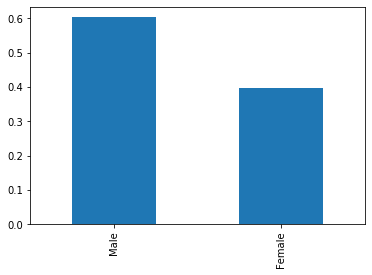

In [11]:
# plot the bar graph customer gender
df['SEX'].value_counts(normalize=True).plot.bar()
plt.xticks([0,1], ['Male', 'Female'])

Text(0.5, 0, 'Clients Age Distribution')

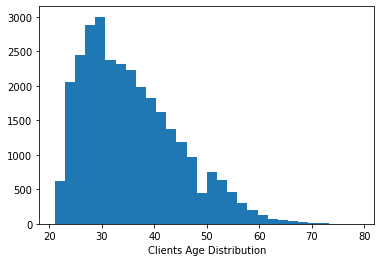

In [12]:
# plot the age distribution
plt.hist(df['AGE'], bins=30)
plt.xlabel('Clients Age Distribution')

## 1.2 Preprocess data

In [13]:
cols = list(df)
cols.insert(0, cols.pop(cols.index('default payment next month')))
df = df.loc[:, cols]

df.rename(columns={"default payment next month": "LABEL"}, inplace=True)

In [14]:
df = df.drop(columns=['ID'])

Now we need to upload the raw csv data to S3

In [15]:
df.to_csv('./data/dataset.csv', index=False)

response = sagemaker_session.upload_data(f'{local_data_dir}/dataset.csv', 
                                         bucket=default_bucket,
                                         key_prefix=data_prefix)
print(response)

s3://sagemaker-us-east-1-697637212537/sagemaker-tutorial/data/dataset.csv


## 1.3 Split DataFrame into Train, Validation & Test Sets

In [16]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=random_state)
X_train, X_val = train_test_split(X_test, test_size=0.2, random_state=random_state)

In [17]:
X_train.to_csv(f'{local_data_dir}/train.csv', header=False, index=False)

response = sagemaker_session.upload_data(f'{local_data_dir}/train.csv',
                                         bucket=default_bucket, 
                                         key_prefix=data_prefix)
train_data_uri = response

In [18]:
X_val.to_csv(f'{local_data_dir}/validation.csv', header=False, index=False)

response = sagemaker_session.upload_data(f'{local_data_dir}/validation.csv',
                                         bucket=default_bucket, 
                                         key_prefix=data_prefix)
validation_data_uri = response

In [19]:
X_test_s3 = X_test.drop(columns=['LABEL'])
X_test_s3.to_csv(f'{local_data_dir}/test.csv', header=False, index=False)

response = sagemaker_session.upload_data(f'{local_data_dir}/test.csv',
                                         bucket=default_bucket, 
                                         key_prefix=data_prefix)
test_data_uri = response

# 2. Train

## 2.1 Use XGBoost as a built-in algorithm

The XGBoost (eXtreme Gradient Boosting) is a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm that attempts to accurately predict a target variable by combining an ensemble of estimates from a set of simpler and weaker models. The XGBoost algorithm performs well in machine learning competitions because of its robust handling of a variety of data types, relationships, distributions, and the variety of hyperparameters that you can fine-tune. You can use XGBoost for regression, classification (binary and multiclass), and ranking problems.

Use the XGBoost built-in algorithm to build an XGBoost training container as shown in the following code example. You can automatically spot the XGBoost built-in algorithm image URI using the SageMaker image_uris.retrieve API (or the `image_uris` API if using Amazon SageMaker Python SDK version 2).

In [20]:
# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")

After specifying the XGBoost image URI, you can use the XGBoost container to construct an estimator using the SageMaker Estimator API and initiate a training job. This XGBoost built-in algorithm mode does not incorporate your own XGBoost training script and runs directly on the input datasets.



In [21]:
train_instance_count = 1
train_instance_type = "ml.m4.xlarge"
content_type = "text/csv"

hyperparameters = {
    "num_round": "50",
    "objective": "binary:logistic",
    "seed": random_state
}

# construct a SageMaker estimator that calls the xgboost-container
xgb_estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container,
                                              hyperparameters=hyperparameters,
                                              role=sagemaker.get_execution_role(),
                                              instance_count=train_instance_count,
                                              instance_type=train_instance_type,
                                              volume_size=5,  # 5 GB
                                              output_path=training_job_output_path,
                                             )

## 2.2 Creating XGBoost model with Hyperparameter Tunining

We will tune four hyperparameters in this examples:

* eta: Step size shrinkage used in updates to prevent overfitting. After each boosting step, you can directly get the weights of new features. The eta parameter actually shrinks the feature weights to make the boosting process more conservative.
* alpha: L1 regularization term on weights. Increasing this value makes models more conservative.
* min_child_weight: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning. In linear regression models, this simply corresponds to a minimum number of instances needed in each node. The larger the algorithm, the more conservative it is.
* max_depth: Maximum depth of a tree. Increasing this value makes the model more complex and likely to be overfitted.

In [22]:
hyperparameter_ranges = {'max_depth': IntegerParameter(1, 10),
                         'eta': ContinuousParameter(0, 1),
                         'gamma': ContinuousParameter(0, 5),
                         'alpha': ContinuousParameter(0, 2),                         
                        }

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. Since we are using built-in XGBoost algorithm here, it emits two predefined metrics: validation:auc and train:auc, and we elected to monitor validation:auc as you can see below. In this case, we only need to specify the metric name and do not need to provide regex. If you bring your own algorithm, your algorithm emits metrics by itself. In that case, you'll need to add a MetricDefinition object here to define the format of those metrics through regex, so that SageMaker knows how to extract those metrics from your CloudWatch logs.



In [23]:
objective_metric_name = 'validation:f1'

Now, we'll create a HyperparameterTuner object, to which we pass:

* The XGBoost estimator we created above
* Our hyperparameter ranges
* Objective metric name and definition
* Tuning resource configurations such as Number of training jobs to run in total and how many training jobs can be run in parallel.

In [24]:
tuner = HyperparameterTuner(xgb_estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=4,
                            max_parallel_jobs=2)

# You can increase the number of jobs, etc. I set them to 10, 4 for the demo purpose

## 2.3 Launch Hyperparameter Tuning job

Now we can launch a hyperparameter tuning job by calling fit() function. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.



In [25]:
# define the data type and paths to the training and validation datasets
train_input = TrainingInput(train_data_uri, content_type="text/csv")
validation_input = TrainingInput(validation_data_uri, content_type="text/csv")

# execute the XGBoost training job
tuner.fit({'train': train_input,
           'validation': validation_input
          }
         )

................................................................................................................!


In [26]:
training_job_info = sagemaker_boto_client.describe_training_job(TrainingJobName=tuner.best_training_job())
training_job_info['HyperParameters']

{'_tuning_objective_metric': 'validation:f1',
 'alpha': '1.6975231959758625',
 'eta': '0.37235900970731817',
 'gamma': '0.29998999707105184',
 'max_depth': '2',
 'num_round': '50',
 'objective': 'binary:logistic',
 'seed': '42'}

In [27]:
tuner.best_training_job()

'sagemaker-xgboost-210510-2140-003-8602b6e8'

## 2.4 Regsiter the model

In [28]:
model_name = f"{training_job_info['TrainingJobName']}-mod"
print(model_name)

model_data = training_job_info["ModelArtifacts"]["S3ModelArtifacts"]
print(model_data)

primary_container = {"Image": xgboost_container, "ModelDataUrl": model_data}

create_model_response = sagemaker_session.create_model(
    name=model_name,
    role=sagemaker_role,
    container_defs=primary_container
)

sagemaker-xgboost-210510-2140-003-8602b6e8-mod
s3://sagemaker-us-east-1-697637212537/sagemaker-tutorial/training_jobs/sagemaker-xgboost-210510-2140-003-8602b6e8/output/model.tar.gz


# 3. Fairness and Explainability with SageMaker Clarify
Amazon SageMaker Clarify helps improve your machine learning models by detecting potential bias and helping explain how these models make predictions. The fairness and explainability functionality provided by SageMaker Clarify takes a step towards enabling AWS customers to build trustworthy and understandable machine learning models.

## 3.1. Clarify configuration

In [29]:
clarify_processor = clarify.SageMakerClarifyProcessor(role=sagemaker_role,
                                                      instance_count=1,
                                                      instance_type='ml.m5.xlarge',
                                                      sagemaker_session=sagemaker_session)

A `DataConfig` object communicates some basic information about data I/O to SageMaker Clarify. We specify where to find the input dataset, where to store the output, the target column (`label`), the header names, and the dataset type.

In [30]:
bias_data_config = clarify.DataConfig(s3_data_input_path=train_data_uri,
                                      s3_output_path=bias_report_output_path,
                                      label='LABEL',
                                      headers=df.columns.to_list(),
                                      dataset_type='text/csv')

A `DataConfig` object communicates some basic information about data I/O to SageMaker Clarify. We specify where to find the input dataset, where to store the output, the target column (`label`), the header names, and the dataset type.

In [31]:
model_config = clarify.ModelConfig(model_name=model_name,
                                   instance_type='ml.m5.xlarge',
                                   instance_count=1,
                                   accept_type='text/csv',
                                   content_type='text/csv')

A `ModelPredictedLabelConfig` provides information on the format of your predictions. XGBoost model outputs probabilities of samples, so SageMaker Clarify invokes the endpoint then uses `probability_threshold` to convert the probability to binary labels for bias analysis. Prediction above the threshold is interpreted as label value 1 and below or equal as label value 0.

In [32]:
predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

SageMaker Clarify also needs information on what the sensitive columns (`facets`) are, what the sensitive features (`facet_values_or_threshold`) may be, and what the desirable outcomes are (`label_values_or_threshold`). SageMaker Clarify can handle both categorical and continuous data for `facet_values_or_threshold` and for `label_values_or_threshold`. In this case we are using categorical data.

We specify this information in the BiasConfig API. Here we use `SEX` as the sensitive group.

group_name is used to form subgroups for the measurement of Conditional Demographic Disparity in Labels (CDDL) and Conditional Demographic Disparity in Predicted Labels (CDDPL) with regards to Simpson’s paradox.


In [33]:
bias_config = clarify.BiasConfig(label_values_or_threshold=[0],
                                facet_name='SEX',
                                facet_values_or_threshold=[1],
                                group_name='AGE'
                                )

## 3.2 Post-training Bias

Computing post-training bias metrics does require a trained model.

Unbiased training data (as determined by concepts of fairness measured by bias metric) may still result in biased model predictions after training. Whether this occurs depends on several factors including hyperparameter choices.

You can run these options separately with `run_pre_training_bias()` and `run_post_training_bias()` or at the same time with `run_bias()` as shown below.

In [34]:
# # uncomment to run clarify job
# clarify_processor.run_bias(data_config=bias_data_config,
#                            bias_config=bias_config,
#                            model_config=model_config,
#                            model_predicted_label_config=predictions_config,
#                            pre_training_methods='all',
#                            post_training_methods='all')

# clarify_bias_job_name = clarify_processor.latest_job.name

In [35]:
!mkdir ./output

mkdir: cannot create directory ‘./output’: File exists


In [36]:
if 'clarify_bias_job_name' in locals():
    s3_client.download_file(Bucket=default_bucket,
                            Key=f'{prefix}/clarify-output/bias/report.pdf',
                            Filename='./output/bias_report.pdf')
    print(f'Downloaded clarify report from previous Clarify job: {clarify_bias_job_name}')
else:
    print(f'Loading pre-generated analysis file...\n')
    
display("Click link below to view the Clarify repot.", FileLink("./output/bias_report.pdf"))

Loading pre-generated analysis file...



'Click link below to view the Clarify repot.'

/root/sm-tutorial/2 hour/output/bias_report.pdf

# 3.3 Explaining Predictions

There are expanding business needs and legislative regulations that require explanations of why a model made the decision it did. SageMaker Clarify uses SHAP to explain the contribution that each input feature makes to the final decision.

Kernel SHAP algorithm requires a baseline (also known as background dataset). Baseline dataset type shall be the same as dataset_type of DataConfig, and baseline samples shall only include features. By definition, baseline should either be a S3 URI to the baseline dataset file, or an in-place list of samples. In this case we chose the latter, and put the first sample of the test dataset to the list.

In [37]:
# # un-comment the code below to run the whole job

# shap_config = sagemaker.clarify.SHAPConfig(
#     baseline=[X_train.median().values[1:].tolist()],
#     num_samples=100,
#     agg_method='mean_abs')

# explainability_data_config = sagemaker.clarify.DataConfig(
#     s3_data_input_path=train_data_uri,
#     s3_output_path=explainability_output_path,
#     label='LABEL',
#     headers=df.columns.to_list(),
#     dataset_type='text/csv')

# clarify_processor.run_explainability(
#     data_config=explainability_data_config,
#     model_config=model_config,
#     explainability_config=shap_config)

# clarify_expl_job_name = clarify_processor.latest_job.name
# print(f'Clarify job {clarify_expl_job_name} ran successfully.')

In [42]:
# download explainability output
if 'clarify_expl_job_name' in locals():
    s3_client.download_file(
        Bucket   = default_bucket, 
        Key      = f'{prefix}/clarify-output/explainability/analysis.json', 
        Filename = './output/explainability_analysis.json'
    )
    print(f'Downloaded analysis from previous Clarify job: {clarify_expl_job_name}\n')
else:
    print(f'Loading pre-generated analysis file...\n')

with open('./output/explainability_analysis.json', 'r') as f:
        analysis_result = json.load(f)



Loading pre-generated analysis file...



In [89]:
# convert analysis result to dataframe
my_dict = analysis_result['explanations']['kernel_shap']["label0"]['global_shap_values']
my_dict = dict(sorted(my_dict.items(), key=lambda item: item[1]))

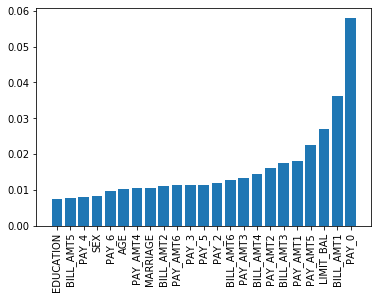

In [90]:
# visualize explainability result
plt.bar(*zip(*my_dict.items()))
ax.barh(y_pos, importance_scores, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)
ax.invert_yaxis() 
plt.xticks(rotation=90)
ax.set_xlabel('SHAP Value (impact on model output)');
plt.show()

# 4. Deploy
After you build and train your models, you can deploy them to get predictions in one of two ways:

1. To set up a persistent endpoint to get predictions from your models, use Amazon SageMaker hosting services. 
2. To get predictions for an entire dataset, use SageMaker batch transform

## 4.1.1 Create an endpoint

SageMaker supports configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way. In addition, the endpoint configuration describes the instance type required for model deployment.

In [91]:
endpoint_config_name = f'DEMO-XGBoostEndpointConfig-{strftime("%Y-%m-%d", gmtime())}'

print(endpoint_config_name)
create_endpoint_config_response = sagemaker_boto_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.t2.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print(f'Endpoint Config Arn: {create_endpoint_config_response["EndpointConfigArn"]}')

DEMO-XGBoostEndpointConfig-2021-05-10
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:697637212537:endpoint-config/demo-xgboostendpointconfig-2021-05-10


Lastly, you need to create the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.



In [92]:
endpoint_name = f'DEMO-XGBoostEndpoint-{strftime("%Y-%m-%d", gmtime())}'

create_endpoint_response = sagemaker_boto_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)


In [ ]:
endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=endpoint_name)
endpoint_status = endpoint_info['EndpointStatus']

while endpoint_status == 'Creating':
    endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=endpoint_name)
    endpoint_status = endpoint_info['EndpointStatus']
    print('Endpoint status:', endpoint_status)
    if endpoint_status == 'Creating':
        time.sleep(60)

Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating


## 4.1.2 Real-time prediction

In [ ]:
# create predictor
predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session)

In [ ]:
# take one sample from test data
sample = X_test.sample(1, random_state=random_state)
test_input = ','.join([str(x) for x in sample.drop(columns=['LABEL']).values.flatten().tolist()])

sample_label = sample['LABEL'].to_list()[0]

In [ ]:
# get prediction
results = predictor.predict(test_input, initial_args = {"ContentType": "text/csv"})
prediction = json.loads(results)

print (f'Model predicted {round(prediction)} - Test label is {sample_label}\nPredicted probablitity of default: {prediction}')

## 4.2 Batch Transform

In [ ]:
the_best_estimator = sagemaker.estimator.Estimator.attach(tuner.best_training_job())

sm_transformer = the_best_estimator.transformer(
    instance_count=1,
    instance_type='ml.m4.xlarge',
    accept = 'text/csv',
    output_path= batch_output
)

sm_transformer.transform(test_data_uri, content_type='text/csv', split_type='Line')

When the batch transform job is complete, SageMaker creates the test.csv.out prediction data saved in the batch_output path, which should be in the following format: `s3://sagemaker-<region>-111122223333/demo-sagemaker-xgboost-adult-income-prediction/batch-prediction`. Run the following AWS CLI to download the output data of the batch transform job

In [ ]:
! aws s3 cp {batch_output} ./output/ --recursive

## 4.3 Evaluate the model with test data

In [ ]:
# create a dataframe from batch transform result
y_pred = pd.read_csv('./output/test.csv.out', header=None)
y_pred.columns = ['probability']

# round the probabilities to get [0, 1]
y_pred['prediction'] = y_pred['probability'].apply(round)
y_pred.head()

In [ ]:
# Generate classification report
y_test = X_test['LABEL']

print(classification_report(y_true=y_test,
                y_pred=y_pred['prediction']))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,  y_pred['probability'])
auc = roc_auc_score(y_test, y_pred['probability'])
lw = 2

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 5. Delete resources


After running the demo, you should remove the resources which were created to avoid accruing cost.

In [ ]:
sagemaker_boto_client.delete_endpoint(EndpointName=endpoint_name)
print(f"Deleted endpoint: {endpoint_name}")

models = sagemaker_boto_client.list_models(NameContains=model_name, MaxResults=50)['Models']
for m in models:
    sagemaker_boto_client.delete_model(ModelName=m['ModelName'])
    print(f"\nDeleted model: {m['ModelName']}")
    time.sleep(1)

s3 = boto3.resource('s3')
bucket = s3.Bucket(default_bucket)
bucket.objects.filter(Prefix=f"{prefix}/").delete()
print(f"\nDeleted contents of {default_bucket}/{prefix}")